In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidnoiseanalysis import plot_psd
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidreadoutanalysis.optimal_filters.config import ConfigThing
import copy
import scipy as sp
%matplotlib inline

# Table of Contents <a class="anchor" id="table"></a>

[1. Import Data](#import)

[2. Raw Data](#rawdata)
* [2.1 Red Data](#redraw)
    * [2.1.1 FPGA Phase](#redrawphase)
* [2.2 IR Data](#irraw)
    * [2.2.1 FPGA Phase](#irrawphase)
* [2.2 Blue Data](#blueraw)
    * [2.2.1 FPGA Phase](#bluerawphase)
* [2.3 Dirty R](#dirtyr)
    
[3. Optimal Filters](#optimalfilters)
* [3.1 Red Data](#ofiltred)
    * [3.1.1 FPGA Phase](#ofiltredphase)
* [3.2 IR Data](#ofiltir)
    * [3.2.1 FPGA Phase](#ofiltirphase)
* [3.2 Blue Data](#ofiltblue)
    * [3.2.1 FPGA Phase](#ofiltbluephase)
* [3.3 Clean R](#cleanr)
    
[4. R Comparison](#rcomparison)

# 1. Import Data <a class="anchor" id="import"></a>
[Table of Contents](#table)

In [2]:
data = np.load(f'/work/jpsmith/Gen3/Fridge_Tests/r_testing/data/white_fridge/10_18_23/wf_ellison3_6000_650GHz.npz')

ir_phase=data['ir_phase']*np.pi
red_phase=data['red_phase']*np.pi
blue_phase=data['blue_phase']*np.pi

del data

# Raw Data  <a class="anchor" id="rawdata"></a> 
[Table of Contents](#table)

## Red Data  <a class="anchor" id="redraw"></a>

### FPGA Phase <a class="anchor" id="redrawphase"></a>

#### Set Threshold and Deadtime

In [3]:
red_phase_readout = MKIDReadout()
red_phase_readout.trigger(red_phase, fs = 1e6, threshold=-0.40, deadtime=60)
print(f'Total photons: {(red_phase_readout.trig>0).sum()}')

Total photons: 22302


#### Triggered Phase Timestream

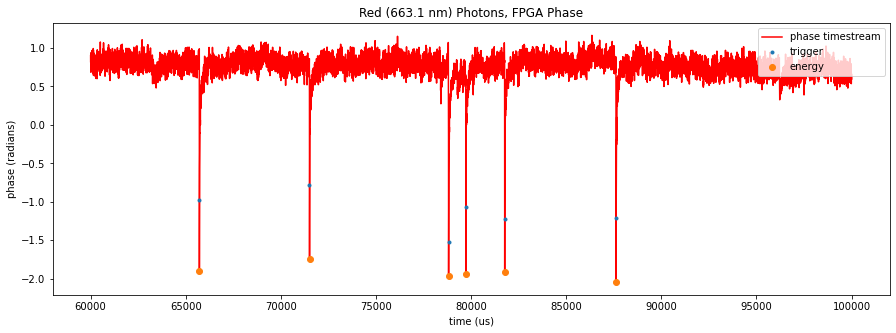

In [4]:
red_phase_readout.plot_triggers(red_phase, fs=1e6, energies=True, color='red', xlim=(60000,100000))
plt.title('Red (663.1 nm) Photons, FPGA Phase');

### Get Dark Level

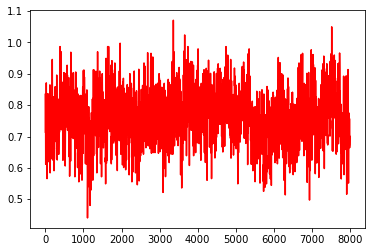

In [5]:
x = slice(10000, 18000)
plt.plot(red_phase[x], color='red')
red_phase_dark_mean = red_phase[x].mean()

#### Phase Histogram

Max Phase: -2.771079054898719 FWHM: 0.19142451688571738 radians


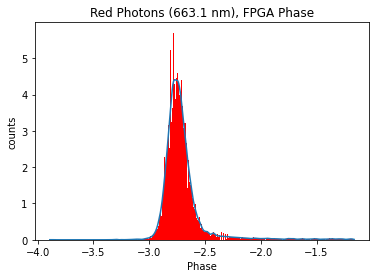

In [6]:
red_phase_max_location, red_phase_fwhm = compute_r(red_phase_readout.photon_energies - red_phase_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_phase_max_location} FWHM: {red_phase_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA Phase');

## IR Data <a class="anchor" id="irraw"></a>
[Table of Contents](#table)

#### Set Threshold and Deadtime

In [9]:
ir_phase_readout = MKIDReadout()
ir_phase_readout.trigger(ir_phase, fs = 1e6, threshold=-0.15, deadtime=60)
print(f'Total photons: {(ir_phase_readout.trig>0).sum()}')

Total photons: 31388


#### Triggered Phase Timestream

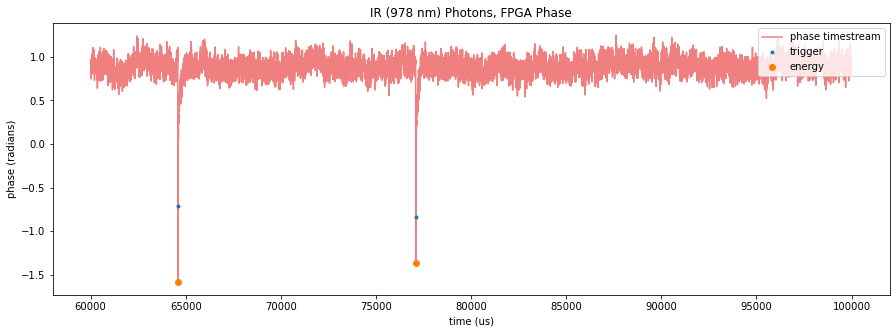

In [10]:
ir_phase_readout.plot_triggers(ir_phase, fs=1e6, energies=True, color='lightcoral', xlim=(60000,100000))
plt.title('IR (978 nm) Photons, FPGA Phase');

### Get Dark Level

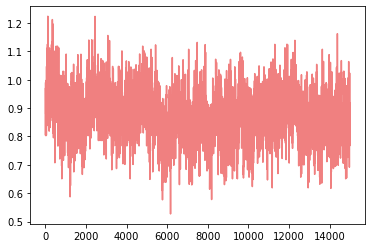

In [11]:
x = slice(35000, 50000)
plt.plot(ir_phase[x], color='lightcoral')
ir_phase_dark_mean = ir_phase[x].mean()

#### Phase Histogram

Max Phase: -2.2987713005625743 FWHM: 0.2361490172423366 radians


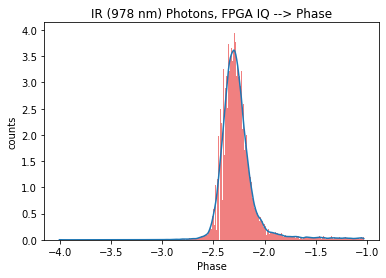

In [12]:
ir_phase_max_location, ir_phase_fwhm = compute_r(ir_phase_readout.photon_energies - ir_phase_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_phase_max_location} FWHM: {ir_phase_fwhm} radians')
plt.title('IR (978 nm) Photons, FPGA IQ --> Phase');

## Blue Data <a class="anchor" id="blueraw"></a>
[Table of Contents](#table)

#### Set Threshold and Deadtime

In [13]:
blue_phase_readout = MKIDReadout()
blue_phase_readout.trigger(blue_phase, fs = 1e6, threshold=-0.8, deadtime=60)
print(f'Total photons: {(blue_phase_readout.trig>0).sum()}')

Total photons: 22133


#### Triggered Phase Timestream

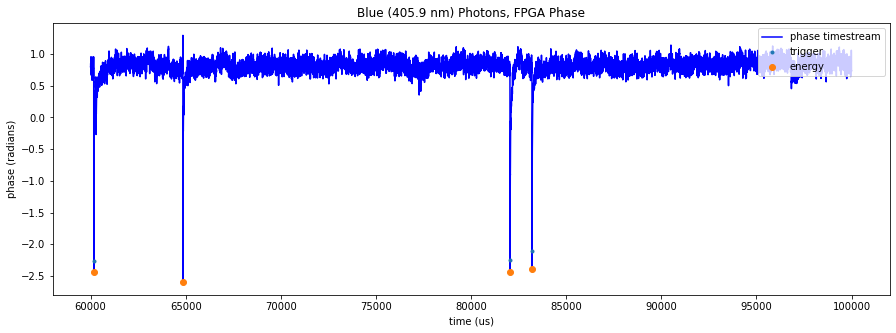

In [14]:
blue_phase_readout.plot_triggers(blue_phase, fs=1e6, energies=True, color='blue', xlim=(60000,100000))
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

### Get Dark Level

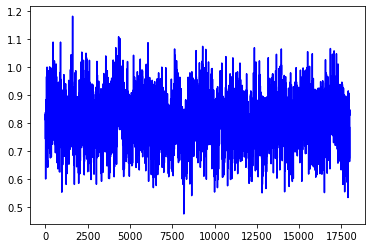

In [15]:
x = slice(42000, 60000)
plt.plot(blue_phase[x],color='blue')
blue_phase_dark_mean = blue_phase[x].mean()

#### Phase Histogram

Max Phase: -3.271328742719113 FWHM: 0.1351108490943127 radians


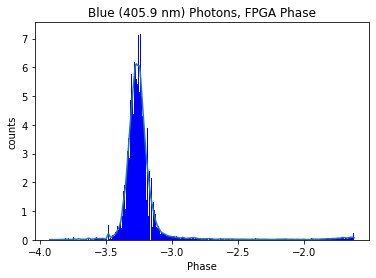

In [16]:
blue_phase_max_location, blue_phase_fwhm = compute_r(blue_phase_readout.photon_energies - blue_phase_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_phase_max_location} FWHM: {blue_phase_fwhm} radians')
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

# Dirty R <a class="anchor" id="dirtyr"></a>
[Table of Contents](#table)

In [17]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 22})

In [22]:
phase_dist_centers = -np.array([blue_phase_max_location, red_phase_max_location, ir_phase_max_location])
phase_dist_fwhm = np.array([blue_phase_fwhm, red_phase_fwhm, ir_phase_fwhm])

In [23]:
lasers = np.array([405.9, 663.1, 978.0])
hc = 1240 #eV
energies = hc / lasers #eV

In [24]:
# fit E(phi)
slope = np.polyfit(phase_dist_centers, energies, 1)[0]
intercept = np.polyfit(phase_dist_centers, energies, 1)[1]
x = np.linspace(-4,-2,10)
y = slope*x+intercept

Text(0.5, 1.0, 'Energy Calibration')

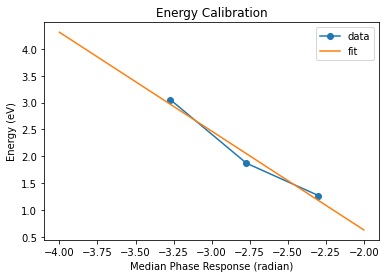

In [25]:
plt.plot(phase_dist_centers, energies, "o-", label='data')
plt.plot(x,y, label='fit')
plt.xlabel('Median Phase Response (radian)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Energy Calibration')

In [26]:
delta_e = slope*phase_dist_fwhm
raw_r = -energies/delta_e

Distribution Centers: [-3.27132874 -2.77107905 -2.2987713 ]
Distribution FWHMs: [0.13511085 0.19142452 0.23614902]
Raw R: [12.27035363  5.30139014  2.91367667]


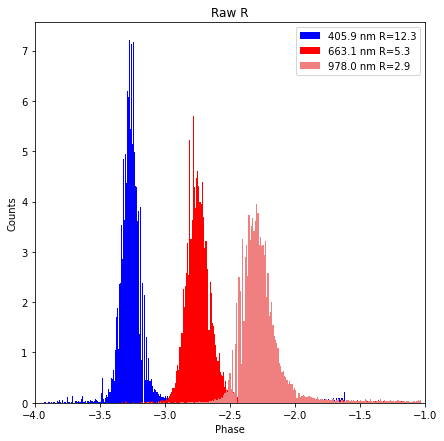

In [28]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(blue_phase_readout.photon_energies - blue_phase_dark_mean, bins='auto', density=True, color='blue', label=f'405.9 nm R={raw_r[0]:.1f}');
ax.hist(red_phase_readout.photon_energies - red_phase_dark_mean, bins='auto', density=True, color='red', label=f'663.1 nm R={raw_r[1]:.1f}');
ax.hist(ir_phase_readout.photon_energies - ir_phase_dark_mean, bins='auto', density=True, color='lightcoral', label=f'978.0 nm R={raw_r[2]:.1f}');
ax.set_xlabel('Phase')
ax.set_xlim([-4,-1])
ax.set_ylabel('Counts')
ax.set_title('Raw R')
ax.legend(loc='upper right')
print(f'Distribution Centers: {phase_dist_centers}')
print(f'Distribution FWHMs: {phase_dist_fwhm}')
print(f'Raw R: {raw_r}')

# Optimal Filters  <a class="anchor" id="optimalfilters"></a>
[Table of Contents](#table)

## Red Data  <a class="anchor" id="ofiltred"></a>

### Phase <a class="anchor" id="ofiltredphase"></a>

array([<AxesSubplot:title={'center':'successful'}, xlabel='frequency [Hz]', ylabel='PSD [dBc / Hz]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='filter coefficient [radians]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>],
      dtype=object)

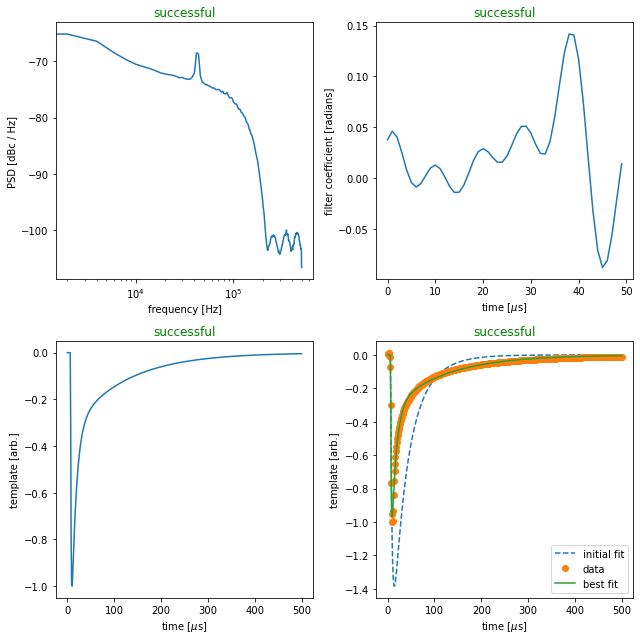

In [30]:
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 1e-6),
('fit', True),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.tf', 30),                        
('pulses.ntemplate', 500), # need to set this larger to calculate covariance matrix in the time domain "accurately" for the number of selected filter coefficients
('pulses.offset', 10),
('pulses.threshold', 6), # sigma above noise
('pulses.separation', 500),
('pulses.min_pulses', 500),
('noise.nwindow', 500), #1000
('noise.isolation', 200),
('noise.max_windows', 2000), # maximum number of nwindows of samples needed before moving on [int]
('noise.max_noise', 5000), #2000
('template.percent', 80),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.cutoff', .1),
('filter.filter_type', 'wiener'),
('filter.nfilter', 50), # for messing around this should be closer to 1000 and ntemplate should be increased to be 5-10x nfilter
                        # need to make sure filter is periodic and this gets hard when the filter is short
('filter.normalize', True)), namespace='')

ofc = Calculator(phase=red_phase, config=cfg, name='simulated')

ofc.calculate(clear=False)

ofc.plot()

### Apply Filter

In [31]:
red_phase_ofilt = sp.signal.convolve(red_phase, ofc.result['filter'], mode='same')

#### Set Threshold and Deadtime

In [32]:
red_phase_readout_ofilt = MKIDReadout()
red_phase_readout_ofilt.trigger(red_phase_ofilt, fs = 1e6, threshold=0.0, deadtime=60)
print(f'Total photons: {(red_phase_readout_ofilt.trig>0).sum()}')

Total photons: 23426


#### Triggered Phase Timestream

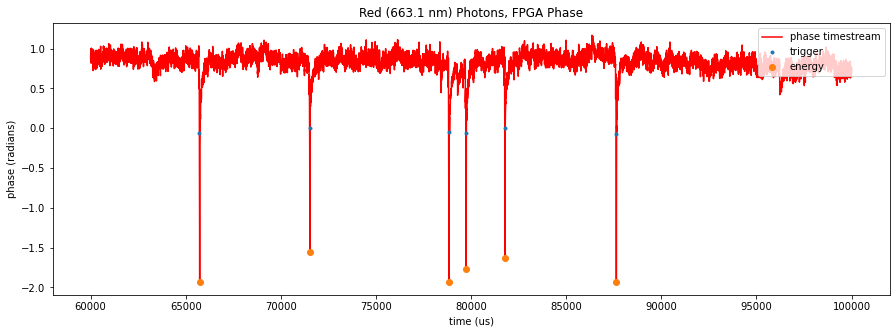

In [33]:
red_phase_readout_ofilt.plot_triggers(red_phase_ofilt, fs=1e6, energies=True, color='red', xlim=(60000,100000))
plt.title('Red (663.1 nm) Photons, FPGA Phase');

## Get Dark Level

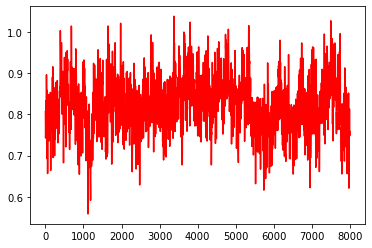

In [34]:
x = slice(10000, 18000)
plt.plot(red_phase_ofilt[x], color='red')
red_phase_ofilt_dark_mean = red_phase_ofilt[x].mean()

#### Phase Histogram

Max Phase: -2.7613222149828736 FWHM: 0.20267224042895604 radians


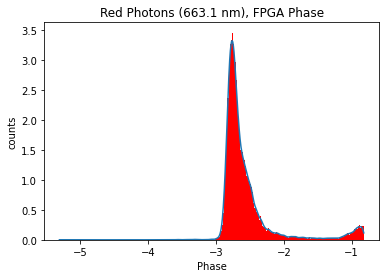

In [35]:
red_phase_ofilt_max_location, red_phase_ofilt_fwhm = compute_r(red_phase_readout_ofilt.photon_energies - red_phase_ofilt_dark_mean, color='red', plot=True)
print(f'Max Phase: {-red_phase_ofilt_max_location} FWHM: {red_phase_ofilt_fwhm} radians')
plt.title('Red Photons (663.1 nm), FPGA Phase');

## IR Data  <a class="anchor" id="ofiltir"></a>

### Phase <a class="anchor" id="ofiltirphase"></a>

array([<AxesSubplot:title={'center':'successful'}, xlabel='frequency [Hz]', ylabel='PSD [dBc / Hz]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='filter coefficient [radians]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>],
      dtype=object)

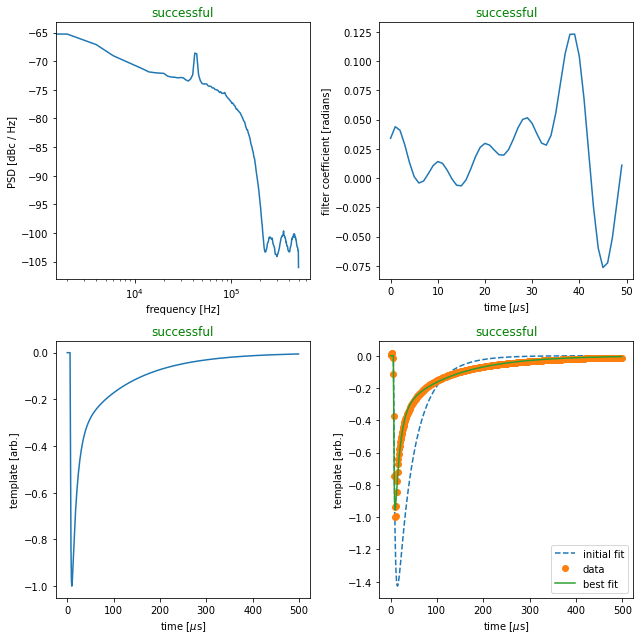

In [36]:
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 1e-6),
('fit', True),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.tf', 30),                        
('pulses.ntemplate', 500), # need to set this larger to calculate covariance matrix in the time domain "accurately" for the number of selected filter coefficients
('pulses.offset', 10),
('pulses.threshold', 6), # sigma above noise
('pulses.separation', 500),
('pulses.min_pulses', 500),
('noise.nwindow', 500), #1000
('noise.isolation', 200),
('noise.max_windows', 2000), # maximum number of nwindows of samples needed before moving on [int]
('noise.max_noise', 5000), #2000
('template.percent', 80),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.cutoff', .1),
('filter.filter_type', 'wiener'),
('filter.nfilter', 50), # for messing around this should be closer to 1000 and ntemplate should be increased to be 5-10x nfilter
                        # need to make sure filter is periodic and this gets hard when the filter is short
('filter.normalize', True)), namespace='')

ofc = Calculator(phase=ir_phase, config=cfg, name='simulated')

ofc.calculate(clear=False)

ofc.plot()

### Apply Filter

In [37]:
ir_phase_ofilt = sp.signal.convolve(ir_phase, ofc.result['filter'], mode='same')

#### Set Threshold and Deadtime

In [38]:
ir_phase_readout_ofilt = MKIDReadout()
ir_phase_readout_ofilt.trigger(ir_phase_ofilt, fs = 1e6, threshold=-0.1, deadtime=60)
print(f'Total photons: {(ir_phase_readout_ofilt.trig>0).sum()}')

Total photons: 31292


#### Triggered Phase Timestream

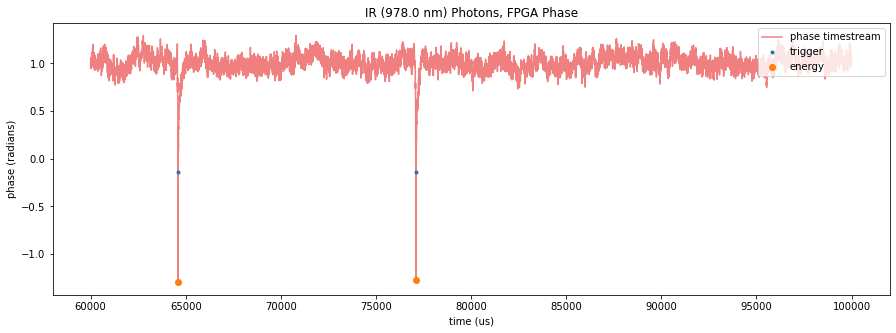

In [39]:
ir_phase_readout_ofilt.plot_triggers(ir_phase_ofilt, fs=1e6, energies=True, color='lightcoral', xlim=(60000,100000))
plt.title('IR (978.0 nm) Photons, FPGA Phase');

## Get Dark Level

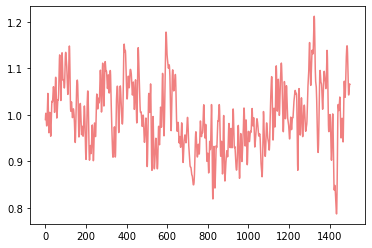

In [40]:
x = slice(20500, 22000)
plt.plot(ir_phase_ofilt[x], color='lightcoral')
ir_phase_ofilt_dark_mean = ir_phase_ofilt[x].mean()

#### Phase Histogram

Max Phase: -2.2670503920592844 FWHM: 0.22029810625948887 radians


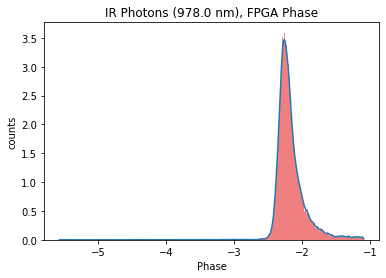

In [41]:
ir_phase_ofilt_max_location, ir_phase_ofilt_fwhm = compute_r(ir_phase_readout_ofilt.photon_energies - ir_phase_ofilt_dark_mean, color='lightcoral', plot=True)
print(f'Max Phase: {-ir_phase_ofilt_max_location} FWHM: {ir_phase_ofilt_fwhm} radians')
plt.title('IR Photons (978.0 nm), FPGA Phase');

## Blue Data  <a class="anchor" id="ofiltblue"></a>

### Phase <a class="anchor" id="ofiltbluephase"></a>

array([<AxesSubplot:title={'center':'successful'}, xlabel='frequency [Hz]', ylabel='PSD [dBc / Hz]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='filter coefficient [radians]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>,
       <AxesSubplot:title={'center':'successful'}, xlabel='time [$\\mu$s]', ylabel='template [arb.]'>],
      dtype=object)

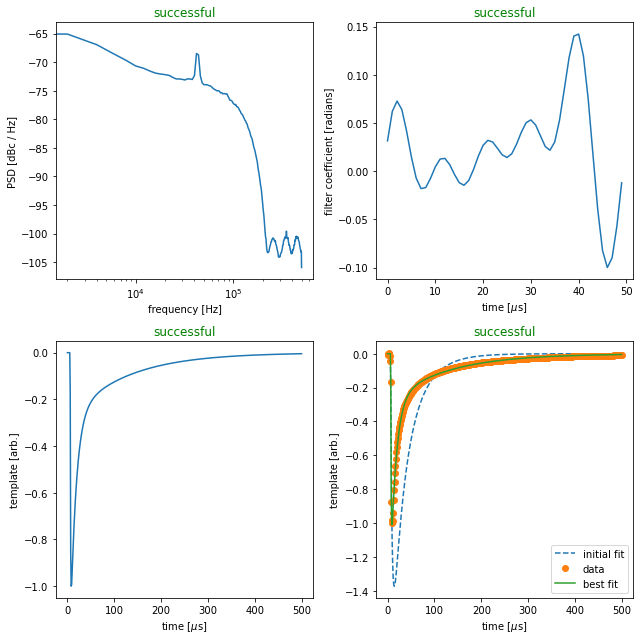

In [42]:
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 1e-6),
('fit', True),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.tf', 30),                        
('pulses.ntemplate', 500), # need to set this larger to calculate covariance matrix in the time domain "accurately" for the number of selected filter coefficients
('pulses.offset', 10),
('pulses.threshold', 6), # sigma above noise
('pulses.separation', 500),
('pulses.min_pulses', 500),
('noise.nwindow', 500), #1000
('noise.isolation', 200),
('noise.max_windows', 2000), # maximum number of nwindows of samples needed before moving on [int]
('noise.max_noise', 5000), #2000
('template.percent', 80),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.cutoff', .1),
('filter.filter_type', 'wiener'),
('filter.nfilter', 50), # for messing around this should be closer to 1000 and ntemplate should be increased to be 5-10x nfilter
                        # need to make sure filter is periodic and this gets hard when the filter is short
('filter.normalize', True)), namespace='')

ofc = Calculator(phase=blue_phase, config=cfg, name='simulated')

ofc.calculate(clear=False)

ofc.plot()

### Apply Filter

In [43]:
blue_phase_ofilt = sp.signal.convolve(blue_phase, ofc.result['filter'], mode='same')

#### Set Threshold and Deadtime

In [44]:
blue_phase_readout_ofilt = MKIDReadout()
blue_phase_readout_ofilt.trigger(blue_phase_ofilt, fs = 1e6, threshold=-1.5, deadtime=60)
print(f'Total photons: {(blue_phase_readout_ofilt.trig>0).sum()}')

Total photons: 21494


#### Triggered Phase Timestream

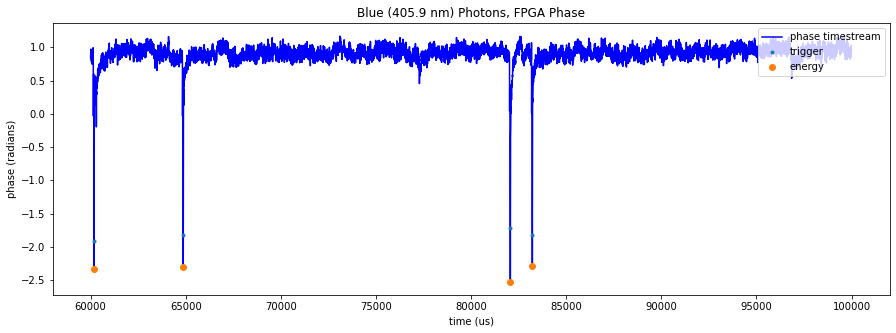

In [45]:
blue_phase_readout_ofilt.plot_triggers(blue_phase_ofilt, fs=1e6, energies=True, color='blue', xlim=(60000,100000))
plt.title('Blue (405.9 nm) Photons, FPGA Phase');

## Get Dark Level

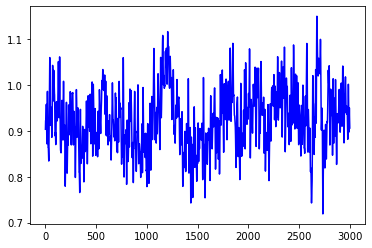

In [46]:
x = slice(16000, 19000)
plt.plot(blue_phase_ofilt[x], color='blue')
blue_phase_ofilt_dark_mean = blue_phase_ofilt[x].mean()

#### Phase Histogram

Max Phase: -3.4655828859039834 FWHM: 0.17967140078717403 radians


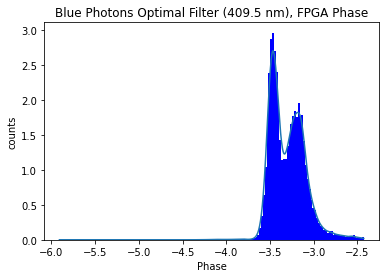

In [47]:
blue_phase_ofilt_max_location, blue_phase_ofilt_fwhm = compute_r(blue_phase_readout_ofilt.photon_energies - blue_phase_ofilt_dark_mean, color='blue', plot=True)
print(f'Max Phase: {-blue_phase_ofilt_max_location} FWHM: {blue_phase_ofilt_fwhm} radians')
plt.title('Blue Photons Optimal Filter (409.5 nm), FPGA Phase');

# "Clean" R <a class="anchor" id="cleanr"></a>
[Table of Contents](#table)

In [48]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 22})

In [49]:
ofilt_phase_dist_centers = -np.array([blue_phase_ofilt_max_location, red_phase_ofilt_max_location, ir_phase_ofilt_max_location])
ofilt_phase_dist_fwhm = np.array([blue_phase_ofilt_fwhm, red_phase_ofilt_fwhm, ir_phase_ofilt_fwhm])

In [52]:
# fit E(phi)
oslope = np.polyfit(ofilt_phase_dist_centers, energies, 1)[0]
ointercept = np.polyfit(ofilt_phase_dist_centers, energies, 1)[1]
ox = np.linspace(-4,-2,10)
oy = oslope*x+ointercept

Text(0.5, 1.0, 'Optimal Filter Energy Calibration')

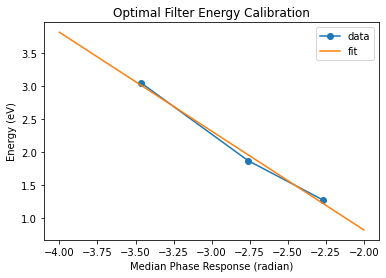

In [53]:
plt.plot(ofilt_phase_dist_centers, energies, "o-", label='data')
plt.plot(ox,oy, label='fit')
plt.xlabel('Median Phase Response (radian)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Optimal Filter Energy Calibration')

In [54]:
odelta_e = oslope*ofilt_phase_dist_fwhm
optimal_r = -energies/odelta_e

## Phase Data  <a class="anchor" id="cleanrphase"></a>

Distribution Centers: [-3.46558289 -2.76132221 -2.26705039]
Distribution FWHMs: [0.1796714  0.20267224 0.22029811]
Optimal Filter R: [11.30484925  6.13464568  3.82660084]


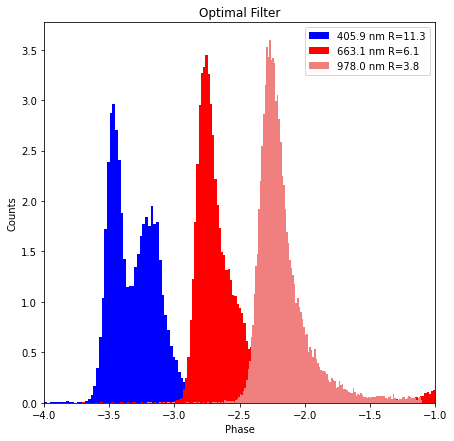

In [59]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.hist(blue_phase_readout_ofilt.photon_energies - blue_phase_ofilt_dark_mean, bins='auto', density=True, color='blue', label=f'405.9 nm R={optimal_r[0]:.1f}');
ax.hist(red_phase_readout_ofilt.photon_energies - red_phase_ofilt_dark_mean, bins='auto', density=True, color='red', label=f'663.1 nm R={optimal_r[1]:.1f}');
ax.hist(ir_phase_readout_ofilt.photon_energies - ir_phase_ofilt_dark_mean, bins='auto', density=True, color='lightcoral', label=f'978.0 nm R={optimal_r[2]:.1f}');
ax.set_xlabel('Phase')
ax.set_xlim([-4,-1])
ax.set_ylabel('Counts')
ax.set_title('Optimal Filter')
ax.legend(loc='upper right')
print(f'Distribution Centers: {ofilt_phase_dist_centers}')
print(f'Distribution FWHMs: {ofilt_phase_dist_fwhm}')
print(f'Optimal Filter R: {optimal_r}')

# 4. R Comparison <a class="anchor" id="rcomparison"></a>
[Table of Contents](#table)

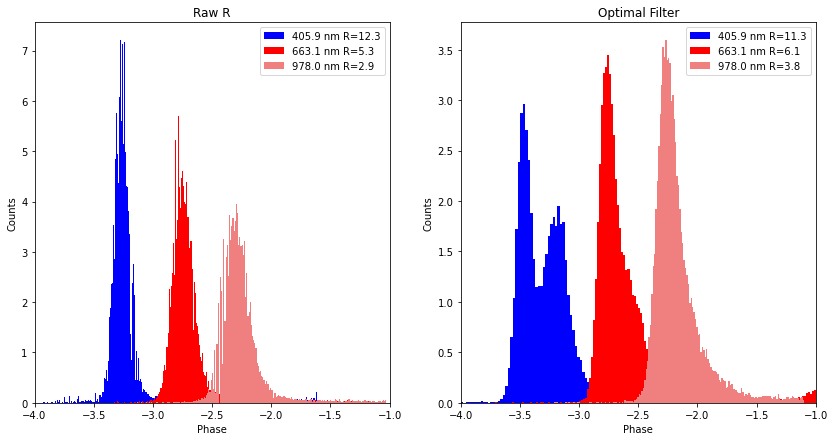

In [58]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(14,7))
ax0.hist(blue_phase_readout.photon_energies - blue_phase_dark_mean, bins='auto', density=True, color='blue', label=f'405.9 nm R={raw_r[0]:.1f}');
ax0.hist(red_phase_readout.photon_energies - red_phase_dark_mean, bins='auto', density=True, color='red', label=f'663.1 nm R={raw_r[1]:.1f}');
ax0.hist(ir_phase_readout.photon_energies - ir_phase_dark_mean, bins='auto', density=True, color='lightcoral', label=f'978.0 nm R={raw_r[2]:.1f}');
ax0.set_xlabel('Phase')
ax0.set_xlim([-4,-1])
ax0.set_ylabel('Counts')
ax0.set_title('Raw R')
ax0.legend(loc='upper right')
ax1.hist(blue_phase_readout_ofilt.photon_energies - blue_phase_ofilt_dark_mean, bins='auto', density=True, color='blue', label=f'405.9 nm R={optimal_r[0]:.1f}');
ax1.hist(red_phase_readout_ofilt.photon_energies - red_phase_ofilt_dark_mean, bins='auto', density=True, color='red', label=f'663.1 nm R={optimal_r[1]:.1f}');
ax1.hist(ir_phase_readout_ofilt.photon_energies - ir_phase_ofilt_dark_mean, bins='auto', density=True, color='lightcoral', label=f'978.0 nm R={optimal_r[2]:.1f}');
ax1.set_xlabel('Phase')
ax1.set_xlim([-4,-1])
ax1.set_ylabel('Counts')
ax1.set_title('Optimal Filter')
ax1.legend(loc='upper right')